In [15]:
#https://github.com/adventuresinML/adventures-in-ml-code/blob/master/keras_lstm.py
    
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# for scaling and inverse_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
 
import pickle

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # range([start,] stop [, step])
        # DataFrame.shift(periods=1, freq=None, axis=0), returns DataFrame
		cols.append(df.shift(i)) 
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    #  concatenating along the columns (axis=1), a DataFrame is returned.
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [16]:
# load dataset
dataset = read_csv('bb-cross-train.csv', header=0)
values = dataset.values
print(values.shape)

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

pickle.dump(scaler, open("min-max-scaler.pkl", 'wb'))

# specify the number of lag hours
n_seq = 3
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_num = 84372 - 20000
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_seq * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)


(84371, 4)
[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]
(84368, 16)
(64372, 12) 64372 (64372, 4)
(64372, 3, 4) (64372, 4) (19996, 3, 4) (19996, 4)


In [170]:
scaled[0]

array([0.87315786, 0.6054564 , 0.9484106 , 0.90546805], dtype=float32)

In [17]:
train_X.shape[2]

4

In [18]:
val_X.shape

(19996, 3, 4)

Train on 64372 samples, validate on 19996 samples
Epoch 1/1000
 - 10s - loss: 0.0515 - val_loss: 0.0208
Epoch 2/1000
 - 9s - loss: 0.0181 - val_loss: 0.0183
Epoch 3/1000
 - 10s - loss: 0.0174 - val_loss: 0.0181
Epoch 4/1000
 - 10s - loss: 0.0171 - val_loss: 0.0219
Epoch 5/1000
 - 10s - loss: 0.0170 - val_loss: 0.0177
Epoch 6/1000
 - 10s - loss: 0.0159 - val_loss: 0.0164
Epoch 7/1000
 - 10s - loss: 0.0151 - val_loss: 0.0161
Epoch 8/1000
 - 10s - loss: 0.0154 - val_loss: 0.0173
Epoch 9/1000
 - 10s - loss: 0.0145 - val_loss: 0.0166
Epoch 10/1000
 - 10s - loss: 0.0143 - val_loss: 0.0158
Epoch 11/1000
 - 10s - loss: 0.0149 - val_loss: 0.0163
Epoch 12/1000
 - 10s - loss: 0.0139 - val_loss: 0.0156
Epoch 13/1000
 - 10s - loss: 0.0134 - val_loss: 0.0159
Epoch 14/1000
 - 10s - loss: 0.0120 - val_loss: 0.0118
Epoch 15/1000
 - 10s - loss: 0.0116 - val_loss: 0.0116
Epoch 16/1000
 - 10s - loss: 0.0109 - val_loss: 0.0116
Epoch 17/1000
 - 10s - loss: 0.0111 - val_loss: 0.0117
Epoch 18/1000
 - 10s - lo

Epoch 149/1000
 - 10s - loss: 0.0062 - val_loss: 0.0070
Epoch 150/1000
 - 10s - loss: 0.0062 - val_loss: 0.0073
Epoch 151/1000
 - 10s - loss: 0.0059 - val_loss: 0.0063
Epoch 152/1000
 - 10s - loss: 0.0060 - val_loss: 0.0070
Epoch 153/1000
 - 10s - loss: 0.0062 - val_loss: 0.0068
Epoch 154/1000
 - 10s - loss: 0.0062 - val_loss: 0.0077
Epoch 155/1000
 - 10s - loss: 0.0059 - val_loss: 0.0066
Epoch 156/1000
 - 10s - loss: 0.0059 - val_loss: 0.0068
Epoch 157/1000
 - 10s - loss: 0.0060 - val_loss: 0.0068
Epoch 158/1000
 - 10s - loss: 0.0061 - val_loss: 0.0073
Epoch 159/1000
 - 10s - loss: 0.0060 - val_loss: 0.0073
Epoch 160/1000
 - 10s - loss: 0.0062 - val_loss: 0.0069
Epoch 161/1000
 - 10s - loss: 0.0059 - val_loss: 0.0071
Epoch 162/1000
 - 10s - loss: 0.0059 - val_loss: 0.0070
Epoch 163/1000
 - 10s - loss: 0.0059 - val_loss: 0.0068
Epoch 164/1000
 - 10s - loss: 0.0060 - val_loss: 0.0068
Epoch 165/1000
 - 10s - loss: 0.0060 - val_loss: 0.0074
Epoch 166/1000
 - 10s - loss: 0.0059 - val_loss:

Epoch 296/1000
 - 10s - loss: 0.0054 - val_loss: 0.0060
Epoch 297/1000
 - 10s - loss: 0.0054 - val_loss: 0.0062
Epoch 298/1000
 - 10s - loss: 0.0053 - val_loss: 0.0058
Epoch 299/1000
 - 10s - loss: 0.0055 - val_loss: 0.0062
Epoch 300/1000
 - 10s - loss: 0.0054 - val_loss: 0.0057
Epoch 301/1000
 - 10s - loss: 0.0053 - val_loss: 0.0059
Epoch 302/1000
 - 10s - loss: 0.0054 - val_loss: 0.0079
Epoch 303/1000
 - 10s - loss: 0.0056 - val_loss: 0.0056
Epoch 304/1000
 - 10s - loss: 0.0052 - val_loss: 0.0062
Epoch 305/1000
 - 10s - loss: 0.0054 - val_loss: 0.0059
Epoch 306/1000
 - 10s - loss: 0.0054 - val_loss: 0.0058
Epoch 307/1000
 - 10s - loss: 0.0055 - val_loss: 0.0070
Epoch 308/1000
 - 10s - loss: 0.0053 - val_loss: 0.0064
Epoch 309/1000
 - 10s - loss: 0.0054 - val_loss: 0.0057
Epoch 310/1000
 - 10s - loss: 0.0052 - val_loss: 0.0062
Epoch 311/1000
 - 10s - loss: 0.0054 - val_loss: 0.0056
Epoch 312/1000
 - 10s - loss: 0.0054 - val_loss: 0.0060
Epoch 313/1000
 - 10s - loss: 0.0054 - val_loss:

Epoch 443/1000
 - 10s - loss: 0.0052 - val_loss: 0.0059
Epoch 444/1000
 - 10s - loss: 0.0051 - val_loss: 0.0064
Epoch 445/1000
 - 10s - loss: 0.0052 - val_loss: 0.0063
Epoch 446/1000
 - 10s - loss: 0.0051 - val_loss: 0.0072
Epoch 447/1000
 - 10s - loss: 0.0051 - val_loss: 0.0059
Epoch 448/1000
 - 10s - loss: 0.0050 - val_loss: 0.0061
Epoch 449/1000
 - 10s - loss: 0.0052 - val_loss: 0.0059
Epoch 450/1000
 - 10s - loss: 0.0050 - val_loss: 0.0057
Epoch 451/1000
 - 10s - loss: 0.0051 - val_loss: 0.0062
Epoch 452/1000
 - 10s - loss: 0.0052 - val_loss: 0.0064
Epoch 453/1000
 - 10s - loss: 0.0052 - val_loss: 0.0059
Epoch 454/1000
 - 10s - loss: 0.0050 - val_loss: 0.0058
Epoch 455/1000
 - 10s - loss: 0.0051 - val_loss: 0.0062
Epoch 456/1000
 - 10s - loss: 0.0051 - val_loss: 0.0061
Epoch 457/1000
 - 10s - loss: 0.0051 - val_loss: 0.0055
Epoch 458/1000
 - 10s - loss: 0.0051 - val_loss: 0.0056
Epoch 459/1000
 - 10s - loss: 0.0049 - val_loss: 0.0055
Epoch 460/1000
 - 10s - loss: 0.0052 - val_loss:

Epoch 590/1000
 - 10s - loss: 0.0051 - val_loss: 0.0061
Epoch 591/1000
 - 10s - loss: 0.0050 - val_loss: 0.0056
Epoch 592/1000
 - 10s - loss: 0.0050 - val_loss: 0.0063
Epoch 593/1000
 - 10s - loss: 0.0050 - val_loss: 0.0055
Epoch 594/1000
 - 10s - loss: 0.0049 - val_loss: 0.0054
Epoch 595/1000
 - 10s - loss: 0.0049 - val_loss: 0.0060
Epoch 596/1000
 - 10s - loss: 0.0050 - val_loss: 0.0058
Epoch 597/1000
 - 10s - loss: 0.0050 - val_loss: 0.0060
Epoch 598/1000
 - 10s - loss: 0.0050 - val_loss: 0.0061
Epoch 599/1000
 - 10s - loss: 0.0052 - val_loss: 0.0054
Epoch 600/1000
 - 10s - loss: 0.0050 - val_loss: 0.0057
Epoch 601/1000
 - 10s - loss: 0.0050 - val_loss: 0.0063
Epoch 602/1000
 - 10s - loss: 0.0051 - val_loss: 0.0061
Epoch 603/1000
 - 10s - loss: 0.0049 - val_loss: 0.0057
Epoch 604/1000
 - 10s - loss: 0.0050 - val_loss: 0.0056
Epoch 605/1000
 - 10s - loss: 0.0050 - val_loss: 0.0058
Epoch 606/1000
 - 10s - loss: 0.0051 - val_loss: 0.0061
Epoch 607/1000
 - 10s - loss: 0.0049 - val_loss:

Epoch 737/1000
 - 9s - loss: 0.0050 - val_loss: 0.0054
Epoch 738/1000
 - 10s - loss: 0.0048 - val_loss: 0.0066
Epoch 739/1000
 - 10s - loss: 0.0049 - val_loss: 0.0060
Epoch 740/1000
 - 10s - loss: 0.0048 - val_loss: 0.0055
Epoch 741/1000
 - 10s - loss: 0.0048 - val_loss: 0.0054
Epoch 742/1000
 - 10s - loss: 0.0048 - val_loss: 0.0056
Epoch 743/1000
 - 10s - loss: 0.0049 - val_loss: 0.0057
Epoch 744/1000
 - 10s - loss: 0.0049 - val_loss: 0.0058
Epoch 745/1000
 - 10s - loss: 0.0050 - val_loss: 0.0055
Epoch 746/1000
 - 10s - loss: 0.0048 - val_loss: 0.0061
Epoch 747/1000
 - 10s - loss: 0.0048 - val_loss: 0.0058
Epoch 748/1000
 - 10s - loss: 0.0049 - val_loss: 0.0055
Epoch 749/1000
 - 10s - loss: 0.0049 - val_loss: 0.0059
Epoch 750/1000
 - 10s - loss: 0.0049 - val_loss: 0.0057
Epoch 751/1000
 - 10s - loss: 0.0049 - val_loss: 0.0057
Epoch 752/1000
 - 10s - loss: 0.0050 - val_loss: 0.0059
Epoch 753/1000
 - 9s - loss: 0.0048 - val_loss: 0.0056
Epoch 754/1000
 - 10s - loss: 0.0049 - val_loss: 0

Epoch 884/1000
 - 10s - loss: 0.0048 - val_loss: 0.0055
Epoch 885/1000
 - 10s - loss: 0.0049 - val_loss: 0.0055
Epoch 886/1000
 - 10s - loss: 0.0048 - val_loss: 0.0058
Epoch 887/1000
 - 10s - loss: 0.0047 - val_loss: 0.0053
Epoch 888/1000
 - 10s - loss: 0.0047 - val_loss: 0.0059
Epoch 889/1000
 - 10s - loss: 0.0049 - val_loss: 0.0056
Epoch 890/1000
 - 10s - loss: 0.0048 - val_loss: 0.0061
Epoch 891/1000
 - 10s - loss: 0.0049 - val_loss: 0.0059
Epoch 892/1000
 - 10s - loss: 0.0048 - val_loss: 0.0056
Epoch 893/1000
 - 10s - loss: 0.0049 - val_loss: 0.0052
Epoch 894/1000
 - 10s - loss: 0.0048 - val_loss: 0.0057
Epoch 895/1000
 - 10s - loss: 0.0050 - val_loss: 0.0055
Epoch 896/1000
 - 10s - loss: 0.0049 - val_loss: 0.0059
Epoch 897/1000
 - 10s - loss: 0.0049 - val_loss: 0.0057
Epoch 898/1000
 - 10s - loss: 0.0048 - val_loss: 0.0066
Epoch 899/1000
 - 10s - loss: 0.0049 - val_loss: 0.0059
Epoch 900/1000
 - 10s - loss: 0.0048 - val_loss: 0.0052
Epoch 901/1000
 - 10s - loss: 0.0047 - val_loss:

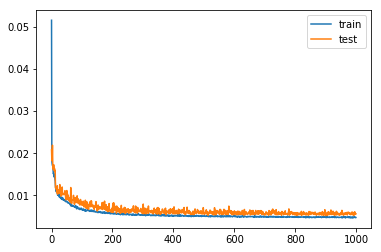

In [20]:
 # design network
K.clear_session()  # Clear previous models from memory.    
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(4))
model.compile(loss='mae', optimizer='adam')

epochs = 1000
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# save the model
model.save("conf1-lstm-model.h5")

In [22]:
model = load_model("conf1-lstm-model.h5")
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.363


In [134]:
(train_X).shape

(50000, 3, 4)

In [135]:
val_X.shape

(49846, 3, 4)

In [136]:
( data.values.shape)

(99849, 4)

In [137]:
print(val_X[0])

[[0.59631574 0.73137456 0.6388744  0.79332715]
 [0.5947368  0.7303252  0.6373111  0.79425395]
 [0.5926316  0.7282266  0.63522667 0.79518074]]


In [138]:
n_features

4

In [139]:
val_y.shape

(49846, 4)

In [ ]:
# load dataset
dataset = read_csv('bb-cross-train.csv', header=0)
values = dataset.values
print(values.shape)

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

pickle.dump(scaler, open("min-max-scaler.pkl", 'wb'))

# specify the number of lag hours
n_seq = 3
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_num = 50000
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_seq * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)


In [23]:
# load test dataset
values = read_csv('bb-cross-test1.csv', header=0).values
print(len(values))
# ensure all data is float
values = values.astype('float32')

# normalize features

scaled = scaler.transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

# specify the number of lag hours
n_seq = 3
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, 1)
print(reframed.shape)
values = reframed.values

# split into input and outputs
n_obs = n_seq * n_features
test_X, test_y = values[:, :n_obs], values[:, n_obs:n_obs+n_features]
print(test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_seq, n_features))
print(test_X.shape, test_y.shape)

204
[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]
(201, 16)
(201, 12) 201 (201, 4)
(201, 3, 4) (201, 4)


In [24]:
K.clear_session()  # Clear previous models from memory.    
model = load_model("conf1-lstm-model.h5")
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.363


In [124]:
test_X.shape

(49846, 12)

In [143]:
test_X[0]

array([[0.59631574, 0.73137456, 0.6388744 , 0.79332715],
       [0.5947368 , 0.7303252 , 0.6373111 , 0.79425395],
       [0.5926316 , 0.7282266 , 0.63522667, 0.79518074]], dtype=float32)

In [144]:
yhat.shape

(49846, 4)

In [151]:
import numpy as np
yhat =  model.predict(np.expand_dims(test_X[0], axis=0))

In [152]:
inv_yhat = scaler.inverse_transform(yhat)

In [153]:
inv_yhat

array([[1122.4075,  692.9786, 1214.8446,  859.0956]], dtype=float32)